In [6]:
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt

In [193]:
eps1 = 1e-6
eps2 = 1e-8

def get_N(l, alpha, b, rho):
    return alpha + b * (rho * l + np.sqrt(l**2 + 1))

def get_Np(l, b, rho):
    return b * (rho + l / np.sqrt(l**2 + 1))

def get_Npp(l, b):
    return b / (np.sqrt(l**2 + 1) ** 3)

def get_G1(l, alpha, b, rho, mu):
    N = get_N(l, alpha, b, rho)
    Np = get_Np(l, b, rho)
    A1 = 1 - Np * ((l + mu)/(2*N) + 1/4)
    A2 = 1 - Np * ((l + mu)/(2*N) - 1/4)
    return A1 * A2

def get_G2(l, alpha, b, rho):
    N = get_N(l, alpha, b, rho)
    Np = get_Np(l, b, rho)
    Npp = get_Npp(l, b)
    return Npp - Np**2/(2*N)

def get_G(l, alpha, b, rho, mu, sigma):
    G1 = get_G1(l, alpha, b, rho, mu)
    G2 = get_G2(l, alpha, b, rho)
    return G1 + G2/(2 * sigma)

def get_l_star(rho): # critical point at minimum of N (N''>0 -> N is convex)
    return - rho / np.sqrt(1 - rho**2)

def get_g(k, a, b, rho, m, sigma):
    # Durrelman condition
    alpha = a/sigma
    mu = m/sigma
    l = k/sigma - mu # k = sigma * (l + mu)
    return get_G(l, alpha, b, rho, mu, sigma)

def get_L_plus(l, alpha, b, rho):
    N = get_N(l, alpha, b, rho)
    Np = get_Np(l, b, rho)
    return 2*N*(1/Np - 1/4) - l

def get_L_minus(l, alpha, b, rho):
    N = get_N(l, alpha, b, rho)
    Np = get_Np(l, b, rho)
    return 2*N*(1/Np + 1/4) - l

def get_g_plus(l, b, rho):
    # L+'(l) = 0 iff g+ = alpha/b
    # defined on [l*, +infty]
    s = np.sqrt(l**2 + 1)
    A1 = (rho * s + l)**2
    A2 = s * (0.5 - b * rho / 4) - b * l / 4
    A3 = rho * l + s
    return A1 * A2 - A3

def get_g_minus(l, b, rho):
    # L-'(l) = 0 iff g- = alpha/b
    # defined on [-infty, l*]
    s = np.sqrt(l**2 + 1)
    A1 = (rho * s + l)**2
    A2 = s * (0.5 + b * rho / 4) + b * l / 4
    A3 = rho * l + s
    return A1 * A2 - A3

def find_g_plus_min(b, rho):
    # Ternary search
    l_upper = 1e6
    l_lower = get_l_star(rho)
    max_iter = 500
    iter_count = 0

    while l_upper - l_lower > eps2:
        iter_count += 1
        if iter_count > max_iter:
            raise RuntimeError(f"Ternary search did not converge within {max_iter} iterations.")
        l1 = l_lower + (l_upper - l_lower) / 3
        l2 = l_upper - (l_upper - l_lower) / 3
        g1 = get_g_plus(l1, b, rho)
        g2 = get_g_plus(l2, b, rho)
        if g1 < g2:
            l_upper = l2
        else:
            l_lower = l1
    argmin_l = (l_lower + l_upper) / 2
    min_g = get_g_plus(argmin_l, b, rho)
    return argmin_l, min_g

def find_g_minus_min(b, rho):
    # Ternary search
    l_upper = get_l_star(rho)
    l_lower = -1e6
    max_iter = 500
    iter_count = 0

    while l_upper - l_lower > eps2:
        iter_count += 1
        if iter_count > max_iter:
            raise RuntimeError(f"Ternary search did not converge within {max_iter} iterations.")
        l1 = l_lower + (l_upper - l_lower) / 3
        l2 = l_upper - (l_upper - l_lower) / 3
        g1 = get_g_minus(l1, b, rho)
        g2 = get_g_minus(l2, b, rho)
        if g1 < g2:
            l_upper = l2
        else:
            l_lower = l1
    argmin_l = (l_lower + l_upper) / 2
    min_g = get_g_minus(argmin_l, b, rho)
    return argmin_l, min_g

def find_s_plus(b, rho):
    l_star = get_l_star(rho)
    argmin_l, min_g = find_g_plus_min(b, rho)

    def obj(l, b, rho):
        # g+(l*) = -sqrt(1-rho**2), find g+(s) = g(l*)
        diff = get_g_plus(l, b, rho) + np.sqrt(1-rho**2)
        if abs(diff) < eps1:
            return 0
        else:
            return diff
    
    if l_star >= argmin_l: # monotonically increasing on [l*, infty]
        s_plus = l_star
    else:
        s_plus = brentq(obj, a=argmin_l, b=1e6, args=(b, rho))
    return s_plus

def find_s_minus(b, rho):
    l_star = get_l_star(rho)
    argmin_l, min_g = find_g_minus_min(b, rho)

    def obj(l, b, rho):
        # g-(l*) = -sqrt(1-rho**2), find g-(s) = g(l*)
        diff = get_g_minus(l, b, rho) + np.sqrt(1-rho**2)
        if abs(diff) < eps1:
            return 0
        else:
            return diff
    
    if l_star <= argmin_l: # monotonically increasing on [-infty, l*]
        s_minus = l_star
    else:
        s_minus = brentq(obj, a=-1e6, b=argmin_l, args=(b, rho))
    return s_minus

def find_l_plus(alpha, b, rho):
    def obj(l, b, rho):
        diff = b * get_g_plus(l, b, rho) - alpha
        if abs(diff) < eps1:
            return 0
        else:
            return diff
    l_plus_lower_bound = get_l_plus_lower_bound(b, rho)
    # exists unique l+ s.t. bg(l+)=alpha, l+ > s+
    l_plus = brentq(obj, a=l_plus_lower_bound, b=1e6, args=(b, rho))
    return l_plus

def find_l_minus(alpha, b, rho):
    def obj(l, alpha, b, rho):
        diff = b * get_g_minus(l, b, rho) - alpha
        if abs(diff) < eps1:
            return 0
        else:
            return diff
    l_minus_upper_bound = get_l_minus_upper_bound(b, rho)
    # exists unique l- s.t. bg(l-)=alpha, l- < s-
    l_minus = brentq(obj, a=-1e6, b=l_minus_upper_bound, args=(alpha, b, rho))
    return l_minus

def get_alpha_lower_bound(b, rho):
    return -b * np.sqrt(1 - rho**2) + eps2

def get_l_plus_lower_bound(b, rho):
    return find_s_plus(b, rho) + eps2

def get_l_minus_upper_bound(b, rho):
    return find_s_minus(b, rho) - eps2

def find_alpha_minus(l_minus, b, rho):
    def obj(alpha, l_minus, b, rho):
        diff = b * get_g_minus(l_minus, b, rho) - alpha
        if abs(diff) < eps1:
            return 0
        else:
            return diff
    alpha_lower_bound = get_alpha_lower_bound(b, rho)
    alpha_minus = brentq(obj, a=alpha_lower_bound, b=1e6, args=(l_minus, b, rho))
    return alpha_minus

def find_alpha_plus(l_plus, b, rho):
    def obj(alpha, l_plus, b, rho):
        diff = b * get_g_plus(l_plus, b, rho) - alpha
        if abs(diff) < eps1:
            return 0
        else:
            return diff
    alpha_lower_bound = get_alpha_lower_bound(b, rho)
    alpha_plus = brentq(obj, a=alpha_lower_bound, b=1e6, args=(l_plus, b, rho))
    return alpha_plus

def find_F(b, rho):
    def obj(l_minus, b, rho):
        alpha = find_alpha_minus(l_minus, b, rho)
        l_plus = find_l_plus(alpha, b, rho)
        L_plus = get_L_plus(l_plus, alpha, b, rho)
        L_minus = get_L_minus(l_minus, alpha, b, rho)
        diff = L_plus - L_minus
        if abs(diff) < eps1:
            return 0
        else:
            return diff
        
    # check weather brentq fails
    # [consider] just do try and except and return lowerbound in exception 
    alpha_lower_bound = get_alpha_lower_bound(b, rho)
    init_l_plus = find_l_plus(alpha_lower_bound, b, rho)
    init_L_plus = get_L_plus(init_l_plus, alpha_lower_bound, b, rho)
    init_l_minus = find_l_minus(alpha_lower_bound, b, rho)
    init_L_minus = get_L_minus(init_l_minus, alpha_lower_bound, b, rho)
    if init_L_plus > init_L_minus:
        return alpha_lower_bound
    
    l_minus_upper_bound = get_l_minus_upper_bound(b, rho)
    l_minus_lower_bound = find_l_minus(1e6, b, rho)
    l_minus_star = brentq(obj, a=l_minus_lower_bound, b=l_minus_upper_bound, args=(b, rho))
    alpha_star = find_alpha_minus(l_minus_star, b, rho)
    
    return max(alpha_lower_bound, alpha_star)

def get_I(alpha, b, rho):
    l_minus = find_l_minus(alpha, b, rho)
    lower_bound_I = get_L_minus(l_minus, alpha, b, rho)
    l_plus = find_l_plus(alpha, b, rho)
    upper_bound_I = get_L_plus(l_plus, alpha, b, rho)
    return [lower_bound_I, upper_bound_I]

In [181]:
# Figure 1
def figure1(b, rho, ylim, xlim):
    l_star = get_l_star(rho)
    s_plus = find_s_plus(b, rho)
    s_minus = find_s_minus(b, rho)
    
    l_minus_lst = np.linspace(xlim[0], l_star, 100)
    l_plus_lst = np.linspace(l_star, xlim[1], 100)
    g_minus_lst = [get_g_minus(l, b, rho) for l in l_minus_lst]
    g_plus_lst = [get_g_plus(l, b, rho) for l in l_plus_lst]
    
    plt.figure(figsize=(8, 4))
    
    plt.plot(l_minus_lst, g_minus_lst, label=r"g-(l) on $[-\infty, l^*]$")
    plt.plot(l_plus_lst, g_plus_lst, label=r"g+(l) on $[l^*, \infty]$")
    
    plt.plot(s_plus, get_g_plus(s_plus, b, rho), 'ro')
    plt.text(s_plus, get_g_plus(s_plus, b, rho), r'$s+$', ha='right', va='bottom', fontsize=14)
    plt.plot(s_minus, get_g_minus(s_minus, b, rho), 'ro')
    plt.text(s_minus, get_g_minus(s_minus, b, rho), r'$s-$', ha='right', va='bottom', fontsize=14)
    
    plt.axvline(l_star, linestyle='--', color='black', linewidth=1)
    plt.axhline(get_g_minus(l_star, b, rho), linestyle='--', color='black', linewidth=1)
    
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.title("Figure 1")
    plt.tight_layout()
    plt.legend()
    plt.show()

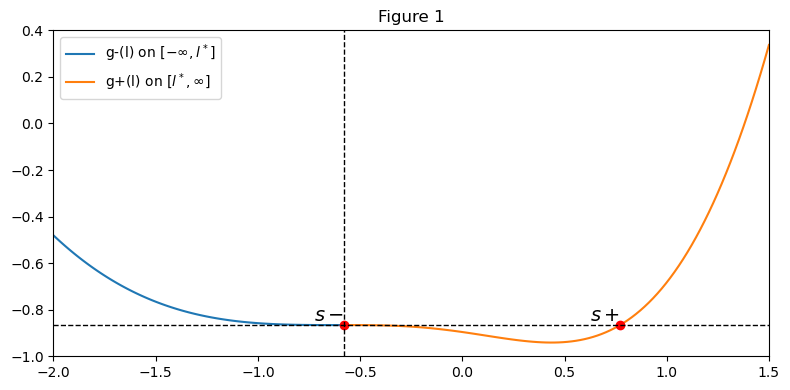

In [182]:
figure1(b=2/3, rho=1/2, ylim=(-1, 0.4), xlim=(-2, 1.5))

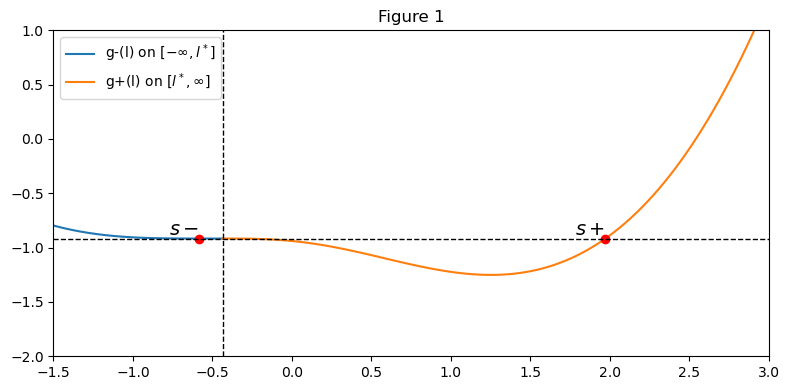

In [183]:
figure1(b=25/21, rho=2/5, ylim=(-2, 1), xlim=(-1.5, 3))

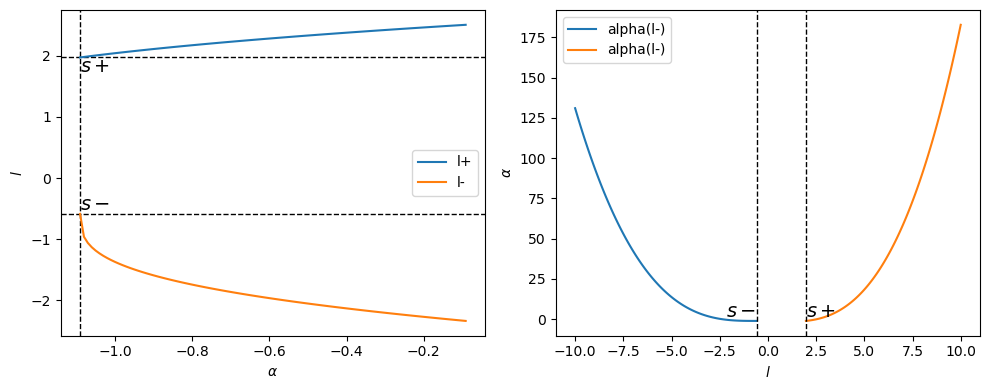

In [184]:
b = 25/21
rho = 2/5

alpha_lower_bound = get_alpha_lower_bound(b, rho)
s_plus = find_s_plus(b, rho)
s_minus = find_s_minus(b, rho)
alpha_lst = np.linspace(alpha_lower_bound, alpha_lower_bound + 1, 100)
l_plus_lst = [find_l_plus(alpha, b, rho) for alpha in alpha_lst]
l_minus_lst = [find_l_minus(alpha, b, rho) for alpha in alpha_lst]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].axhline(s_plus, linestyle='--', color='black', linewidth=1)
axes[0].axhline(s_minus, linestyle='--', color='black', linewidth=1)
axes[0].axvline(alpha_lower_bound, linestyle='--', color='black', linewidth=1)
axes[0].text(alpha_lower_bound, s_plus, r'$s+$', ha='left', va='top', fontsize=14)
axes[0].text(alpha_lower_bound, s_minus, r'$s-$', ha='left', va='bottom', fontsize=14)
axes[0].plot(alpha_lst, l_plus_lst, label='l+')
axes[0].plot(alpha_lst, l_minus_lst, label='l-')
axes[0].set_ylabel(r"$l$")
axes[0].set_xlabel(r"$\alpha$")
axes[0].legend()

l_minus_upper_bound = get_l_minus_upper_bound(b, rho)
l_plus_lower_bound = get_l_plus_lower_bound(b, rho)
l_minus_lst = np.linspace(-10, l_minus_upper_bound, 100)
l_plus_lst = np.linspace(l_plus_lower_bound, 10, 100)
alpha_minus_lst = [find_alpha_minus(l_minus, b, rho) for l_minus in l_minus_lst]
alpha_plus_lst = [find_alpha_plus(l_plus, b, rho) for l_plus in l_plus_lst]
axes[1].plot(l_minus_lst, alpha_minus_lst, label='alpha(l-)')
axes[1].plot(l_plus_lst, alpha_plus_lst, label='alpha(l-)')
axes[1].set_xlabel(r"$l$")
axes[1].set_ylabel(r"$\alpha$")
axes[1].legend()
axes[1].axvline(s_plus, linestyle='--', color='black', linewidth=1)
axes[1].axvline(s_minus, linestyle='--', color='black', linewidth=1)
axes[1].text(s_plus, alpha_lower_bound, r'$s+$', ha='left', va='bottom', fontsize=14)
axes[1].text(s_minus, alpha_lower_bound, r'$s-$', ha='right', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()

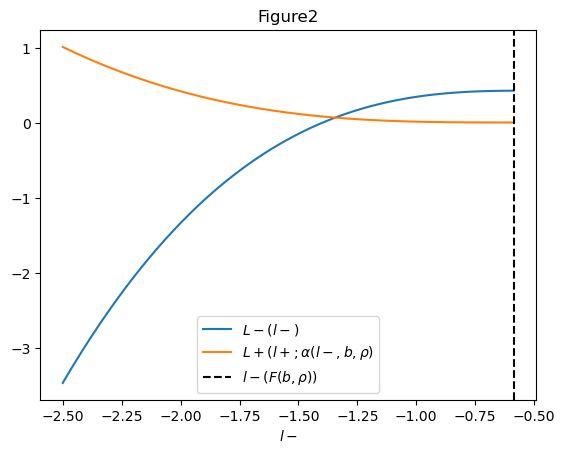

In [192]:
b = 25/21
rho = 2/5

l_minus_upper_bound = get_l_minus_upper_bound(b, rho)
l_minus_lst = np.linspace(-2.5, l_minus_upper_bound, 100)
alpha_lst = [find_alpha_minus(l_minus, b, rho) for l_minus in l_minus_lst]
l_plus_lst = [find_l_plus(alpha, b, rho) for alpha in alpha_lst]
L_minus_lst = [get_L_minus(l_minus, alpha, b, rho) for l_minus, alpha in zip(l_minus_lst, alpha_lst)]
L_plus_lst = [get_L_plus(l_plus, alpha, b, rho) for l_plus, alpha in zip(l_plus_lst, alpha_lst)]
plt.plot(l_minus_lst, L_minus_lst, label=r'$L-(l-)$')
plt.plot(l_minus_lst, L_plus_lst, label=r'$L+(l+;\alpha(l-,b,\rho)$')
plt.axvline(l_minus_upper_bound, linestyle="--", color='black', label=r"$l-(F(b,\rho))$")
plt.title("Figure2")
plt.xlabel(r"$l-$")
plt.legend()
plt.show()

In [232]:
def figure3(b, rho, alpha_upper_bound):
    alpha_lower_bound = get_alpha_lower_bound(b, rho)
    s_plus = find_s_plus(b, rho)
    s_minus = find_s_minus(b, rho)
    alpha_lst = np.linspace(alpha_lower_bound, alpha_upper_bound, 100)
    l_plus_lst = [find_l_plus(alpha, b, rho) for alpha in alpha_lst]
    l_minus_lst = [find_l_minus(alpha, b, rho) for alpha in alpha_lst]
    L_plus_lst = [get_L_plus(l_plus, alpha, b, rho) for l_plus, alpha in zip(l_plus_lst, alpha_lst)]
    L_minus_lst = [get_L_minus(l_minus, alpha, b, rho) for l_minus, alpha in zip(l_minus_lst, alpha_lst)]
    F = find_F(b, rho)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    axes[0].axhline(s_plus, linestyle='--', color='black', linewidth=1)
    axes[0].axhline(s_minus, linestyle='--', color='black', linewidth=1)
    axes[0].axvline(alpha_lower_bound, linestyle='--', color='black', linewidth=1)
    axes[0].text(alpha_lower_bound, s_plus, r'$s+$', ha='left', va='top', fontsize=14)
    axes[0].text(alpha_lower_bound, s_minus, r'$s-$', ha='left', va='bottom', fontsize=14)
    axes[0].plot(alpha_lst, l_plus_lst, label='l+')
    axes[0].plot(alpha_lst, l_minus_lst, label='l-')
    axes[0].set_ylabel(r"$l$")
    axes[0].set_xlabel(r"$\alpha$")
    
    axes[1].plot(l_plus_lst, L_plus_lst, label=r"L+(l+)")
    axes[1].plot(l_minus_lst, L_minus_lst, label=r"L-(l-)")
    axes[1].set_xlabel(r"l")
    axes[1].set_ylabel(r"L")
    
    axes[2].plot(alpha_lst, L_plus_lst, label=r"$L+$")
    axes[2].plot(alpha_lst, L_minus_lst, label=f"$L-$")
    axes[2].axvline(F, linestyle="--", color='red', label=r"$F(b,\rho)$")

    alpha_arr = np.array(alpha_lst)
    L_plus_arr = np.array(L_plus_lst)
    L_minus_arr = np.array(L_minus_lst)
    mask = alpha_arr > F
    
    axes[2].fill_between(
        alpha_arr[mask],
        L_plus_arr[mask],
        L_minus_arr[mask],
        color='gray', alpha=0.3,
        label=r"$\mu \in I_{\alpha,b,\rho}$"
    )
    axes[2].set_ylabel(r"L")
    axes[2].set_xlabel(r"$\alpha$")
    
    for ax in axes:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    fig.tight_layout()
    fig.subplots_adjust(right=0.85)
    plt.show()
    
    plt.show()

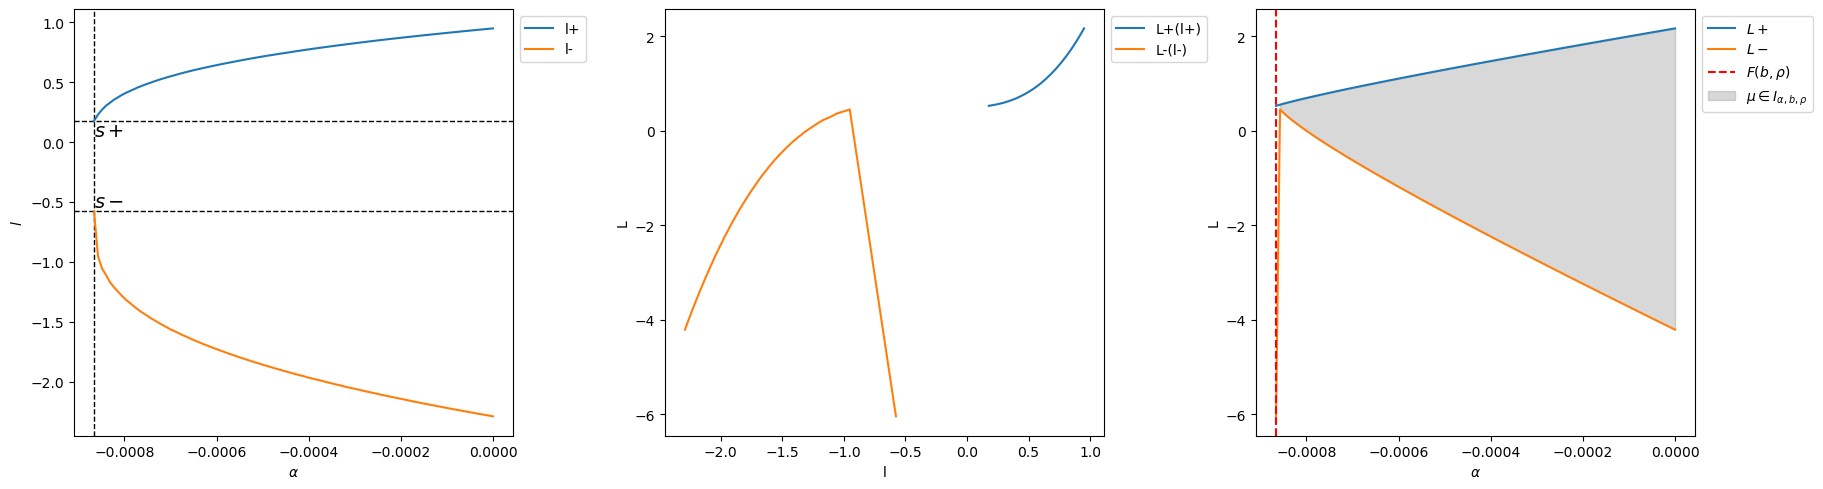

F(b,rho):-0.0009
$\alpha$ lower bound -0.0009


In [233]:
# I need to handle the spike point below, especially when b is small enough
b = 0.001
rho = 0.5
figure3(b, rho, alpha_upper_bound=0)
print(f"F(b,rho):{find_F(b, rho):.4f}")
print(r"$\alpha$ lower bound", f"{get_alpha_lower_bound(b, rho):.4f}")

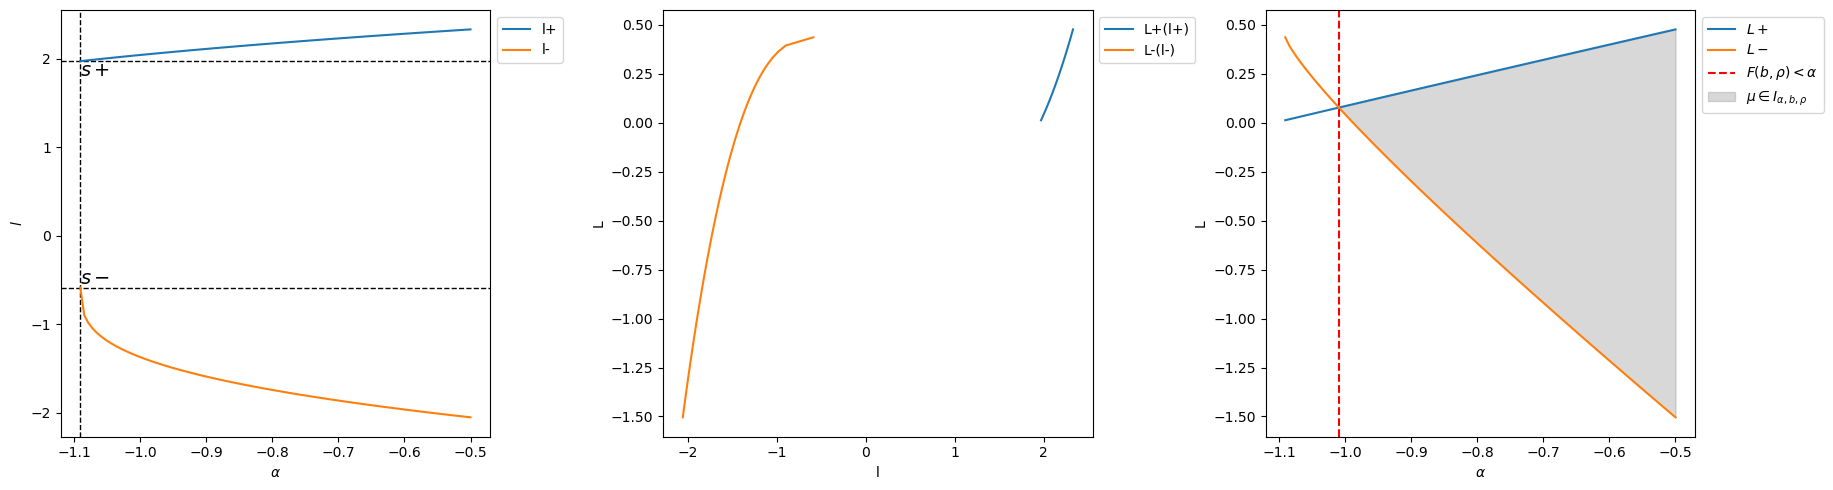

F(b,rho):-1.0099
$\alpha$ lower bound -1.0911


In [227]:
b = 25/21
rho = 2/5
figure3(b, rho, alpha_upper_bound=-0.5)
print(f"F(b,rho):{find_F(b, rho):.4f}")
print(r"$\alpha$ lower bound", f"{get_alpha_lower_bound(b, rho):.4f}")

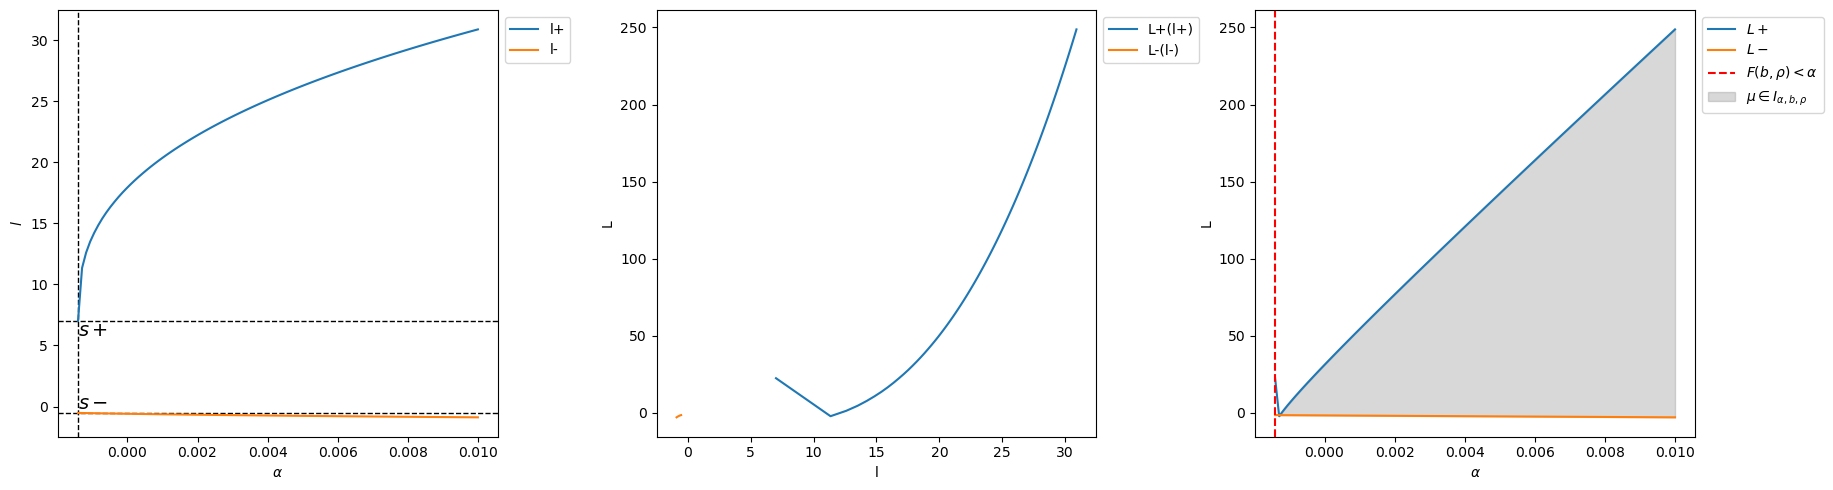

F(b,rho):-0.0014
$\alpha$ lower bound -0.0014


In [228]:
b = 0.01
rho = -0.99
figure3(b, rho, alpha_upper_bound=0.01)
print(f"F(b,rho):{find_F(b, rho):.4f}")
print(r"$\alpha$ lower bound", f"{get_alpha_lower_bound(b, rho):.4f}")

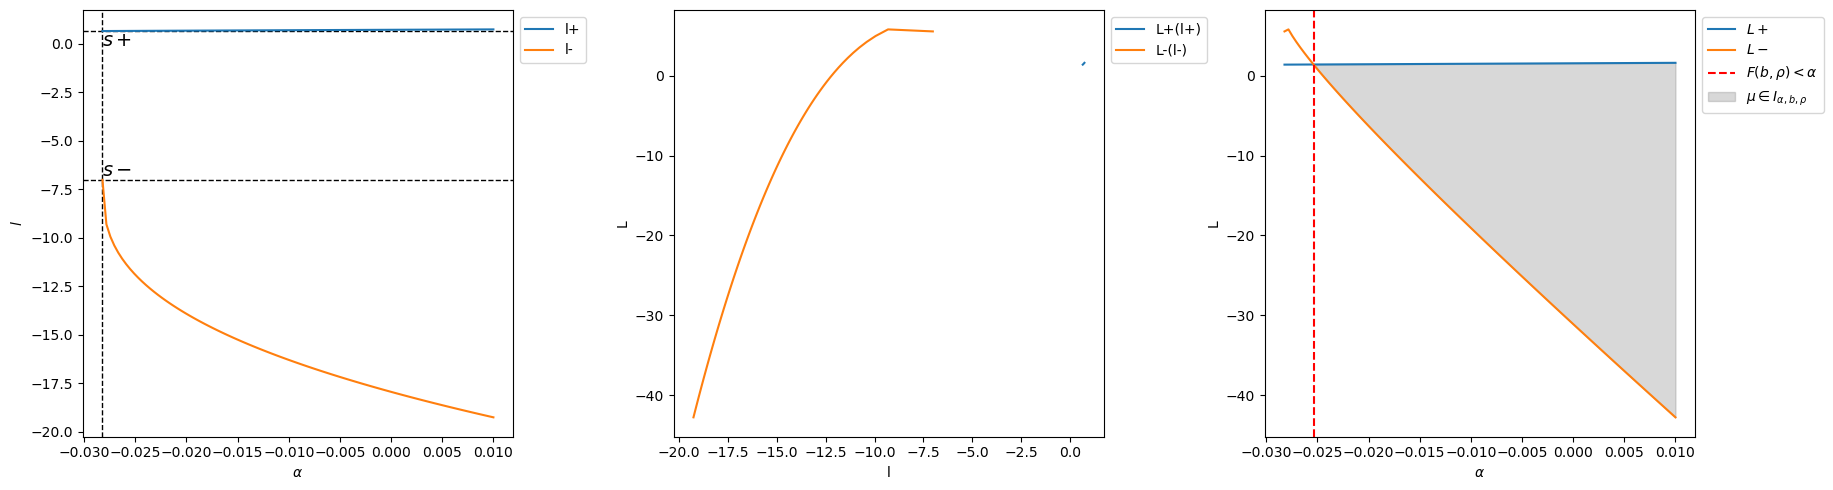

F(b,rho):-0.0254
$\alpha$ lower bound -0.0282


In [229]:
b = 0.2
rho = 0.99
figure3(b, rho, alpha_upper_bound=0.01)
print(f"F(b,rho):{find_F(b, rho):.4f}")
print(r"$\alpha$ lower bound", f"{get_alpha_lower_bound(b, rho):.4f}")

# G1: alpha, b, rho, mu
Now, we know the Fukosawa non-butterfly arbitrage necessary conditions
1. A1: $\alpha + b\sqrt(1 - \rho^2) > 0, |\rho| < 1, b > 0$ 
2. B1: $b * (1 - \rho) < 2$
3. $\alpha > F(b,\rho)$
4. $\mu \in I_{\alpha, b, \rho} = [L-(l-), L+(l+)]$


# G2

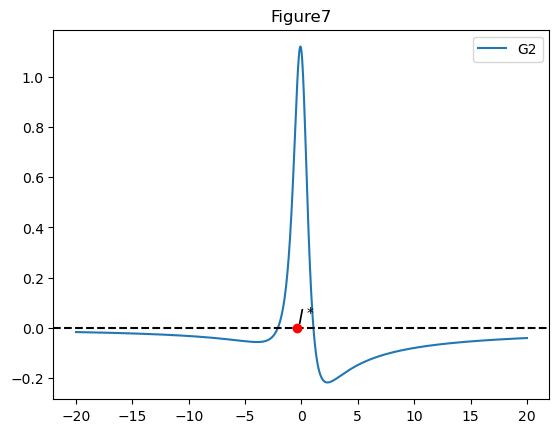

In [245]:
b = 25/21
rho = 2/5
alpha = 1/10
l_star = get_l_star(rho)
l_lst = np.linspace(-20, 20, 1000)
G2_lst = [get_G2(l, alpha, b, rho) for l in l_lst]
plt.plot(l_lst, G2_lst, label='G2')
plt.axhline(0, linestyle='--', color='black')
plt.plot(l_star, 0, 'ro')
plt.text(l_star, 0, r'$l^*$', ha='left', va='bottom', fontsize=14)
         
plt.title(r"Figure7")
plt.legend()
plt.show()

|# Algorithm
1. Fit unconstrained SVI curve to market data and get raw parameters
2. If the parameters do not violate Durrelman's condition, use them
3. choose $\rho\in[-1,1]$ and $b>0$ such that $b(1+|\rho|)\le2$ by choosing $b'\in[0,1]$ and setting $b=b' \frac{2}{1+|\rho|}$
4. compute numerically $F(b,\rho)$, and parametrize $\alpha$ by setting $\alpha = F(b,\rho) + \epsilon$ for $\epsilon > 0$
5. compute numerically $(L-, L+)$ for this value of $\mu$, and parametrize $\mu$ by setting $\mu = \frac{1+q}{2}L_{+} + \frac{1-q}{2}L_{-}$ for $q \in [-1, 1]$